In [1]:
import torch.nn.functional as F
from torch.utils import data
import torch
import os
import random
import numpy as np

data = np.load( "CRP128-small.npy" )
print(data.shape)
data = np.random.permutation(data)

sample=32
pixels=sample*501

if sample<128:
        data = data.transpose(2,1,0,3)
        data = np.random.permutation(data)
        data = data[0:sample]
        print(data.shape)
        data = data.transpose(2,1,0,3)
        print(data.shape)

data = torch.from_numpy(np.stack(data, 0))
data = data.float()
print(data.dtype)

X= data.reshape(16*504*sample, 204)
print(X.shape)

X_mean = torch.mean(X,dim=0,keepdim=True)
print(X_mean.shape)

X_mean = X_mean.reshape(1,1,204)
print(X_mean.shape)

indice1 = 300
indice4 = len(data)

train = data[0:indice1]
valid = data[indice1:(indice1+100)]
test = data[(indice4-100):indice4]

print(train.shape)
print(valid.shape)
print(test.shape)
print(train.dtype)

train = torch.reshape(train,(-1, sample, 204))
valid = torch.reshape(valid,(-1, sample, 204))
test = torch.reshape(test,(-1, sample, 204))

x = train
print(x.shape)
temp = (x - X_mean.repeat(x.size(0),x.size(1),1))        
temp = temp * temp
w = F.adaptive_avg_pool1d(temp,[1])
print(w.shape)
w, idx = torch.sort(w, dim=1, descending=True)
b,c,_ = x.size()
train = torch.zeros_like(x)
idx = idx[:,:]
for i in range(b):
        for j in range(c):
                train[i][j][:] = x[i][idx[i][j]][:]
x = test
temp = (x - X_mean.repeat(x.size(0),x.size(1),1))   
temp = temp * temp
w = F.adaptive_avg_pool1d(temp,[1])
w, idx = torch.sort(w, dim=1, descending=True)
b,c,_ = x.size()
test = torch.zeros_like(x)
idx = idx[:,:]
for i in range(b):
        for j in range(c):
                test[i][j][:] = x[i][idx[i][j]][:]

x = valid
temp = (x - X_mean.repeat(x.size(0),x.size(1),1))   
temp = temp * temp
w = F.adaptive_avg_pool1d(temp,[1])
w, idx = torch.sort(w, dim=1, descending=True)
b,c,_ = x.size()
valid = torch.zeros_like(x)
idx = idx[:,:]
for i in range(b):
        for j in range(c):
                valid[i][j][:] = x[i][idx[i][j]][:]


print(train.shape)
print(valid.shape)
print(test.shape)

np.save("train.npy", train)
np.save("test.npy", test)
np.save("valid.npy", valid)


/Users/fishzero/opt/anaconda3/envs/cpu/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(504, 16, 128, 204)
(32, 16, 504, 204)
(504, 16, 32, 204)
torch.float32
torch.Size([258048, 204])
torch.Size([1, 204])
torch.Size([1, 1, 204])
300
504
torch.Size([300, 16, 32, 204])
torch.Size([100, 16, 32, 204])
torch.Size([100, 16, 32, 204])
torch.float32
torch.Size([4800, 32, 204])
torch.Size([4800, 32, 1])
torch.Size([4800, 32, 204])
torch.Size([1600, 32, 204])
torch.Size([1600, 32, 204])


In [2]:
import torch.nn.functional as F
from torch.utils import data
import torch
import os
import random
import numpy as np

indice1 = 300
p=sample

train = np.load("train.npy")
train = torch.from_numpy(np.stack(train, 0))
test = np.load("test.npy")
test = torch.from_numpy(np.stack(test, 0))
valid = np.load("valid.npy")
valid = torch.from_numpy(np.stack(valid, 0))

print(train.shape)
print(valid.shape)
print(test.shape)

label=np.arange(0,16,1)
label = label.astype(np.float32)
train_label = torch.from_numpy(np.tile(label, indice1)) 
valid_label = torch.from_numpy(np.tile(label, 100))
test_label  = torch.from_numpy(np.tile(label, 100))

print(train_label.dtype)
print(train_label.shape)
print(valid_label.shape)
print(test_label.shape)


from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.autograd import Variable

train_dataset = TensorDataset(train, train_label)
valid_dataset = TensorDataset(valid, valid_label)
test_dataset = TensorDataset(test, test_label)
batch=32

train_loader = DataLoader(
    dataset = train_dataset,
    batch_size = batch,             # 每批提取的数量
    shuffle= True,             # 要不要打乱数据
)

valid_loader = DataLoader(
    dataset = valid_dataset,
    batch_size = batch,             # 每批提取的数量
    shuffle= True,             # 要不要打乱数据
)

test_loader = DataLoader(
    dataset = test_dataset,
    batch_size = batch,             # 每批提取的数量
    shuffle= True,             # 要不要打乱数据
)

torch.Size([4800, 32, 204])
torch.Size([1600, 32, 204])
torch.Size([1600, 32, 204])
torch.float32
torch.Size([4800])
torch.Size([1600])
torch.Size([1600])


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import argparse

from torch.autograd import Variable
import torch.optim as optim

parser = argparse.ArgumentParser(description='Sequence Modeling')
parser.add_argument('--batch_size', type=int, default=32, metavar='N',
                    help='batch size (default: 128)')
parser.add_argument('--cuda', action='store_true', default=False,
                    help='Disable cuda for training')
parser.add_argument('--dropout', type=float, default=0.45,
                    help='dropout applied to layers (default: 0.05)')
parser.add_argument('--clip', type=float, default=0.35,
                    help='gradient clip, -1 means no clip (default: -1)')
parser.add_argument('--epochs', type=int, default=20,
                    help='upper epoch limit (default: 20)')
parser.add_argument('--levels', type=int, default=4,
                    help='# of levels (default: 8)')
parser.add_argument('--log-interval', type=int, default=1, metavar='N',
                    help='report interval (default: 100')
parser.add_argument('--lr', type=float, default=1e-4,
                    help='initial learning rate (default: 2e-3)')
parser.add_argument('--optim', type=str, default='Adam',
                    help='optimizer to use (default: Adam)')
parser.add_argument('--seed', type=int, default=1111,
                    help='random seed (default: 1111)')
parser.add_argument('--seq_len', type=int, default=204)

args = parser.parse_args([])

if torch.cuda.is_available():
    if not args.cuda:
        print("WARNING: You have a CUDA device, so you should probably run with --cuda")
print(args)

torch.manual_seed(args.seed)
batch_size = args.batch_size  
epochs = args.epochs  
input_channels = sample
n_classes = 16
steps = 0


import math
from einops import rearrange
from torch.nn import init
from torch.nn.utils import weight_norm

class MUSEAttention(nn.Module):

    def __init__(self, p=32, d_model=204, d_k=17*2, h=3, k=5, dropout=.1):

        super(MUSEAttention, self).__init__()
        self.fc_q = nn.Linear(d_model, h * d_k)
        self.fc_k = nn.Linear(d_model, h * d_k)
        self.fc_v = nn.Linear(d_model, h * d_k)

        self.softmax=nn.Softmax(-1)

        self.d_model = d_model
        self.d_k = d_k
        self.d_v = d_k
        self.h = h

        self.init_weights()
        self.c = nn.Conv1d(p, p, kernel_size=k,stride=1, padding=2, groups=p)

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                init.normal_(m.weight, std=0.001)
                if m.bias is not None:
                    init.constant_(m.bias, 0)

    def forward(self, x, attention_mask=None, attention_weights=None):
        b, c, l = x.shape

        q = self.fc_q(x).view(b, c, self.h, self.d_k).permute(0, 2, 1, 3) 
#        print("q:",q.shape)
        k = self.fc_k(x).view(b, c, self.h, self.d_k).permute(0, 2, 3, 1) 
#        print("k:",k.shape)
        v = self.fc_v(x).view(b, c, self.h, self.d_v).permute(0, 2, 1, 3) 
        att = torch.matmul(q, k) / np.sqrt(self.d_k)  
        if attention_weights is not None:
            att = att * attention_weights

        att = torch.softmax(att, dim=1)
        att = torch.matmul(att, v).permute(0, 2, 1, 3).contiguous().view(b, c, self.h * self.d_v) # (b_s, nq, h*d_v)
        v = v.permute(0, 2, 1, 3).contiguous().view(b, c, self.h * self.d_v)
#        print("v:",v.shape)        
        dw = self.c(v)
        out_att = att+dw
        return out_att

class TemporalConvNet(nn.Module):
    def __init__(self, p=16, l=204):
        super(TemporalConvNet, self).__init__()

        self.tconv1 = weight_norm(nn.Conv1d(p, p, kernel_size=3,stride=1, padding=1, groups=1))
        self.relu1 = nn.GELU()
        self.tconv2 = weight_norm(nn.Conv1d(p, p, kernel_size=5,stride=1, padding=2*2, dilation=2, groups=1))
        self.relu2 = nn.GELU()
        self.tconv3 = weight_norm(nn.Conv1d(p, p, kernel_size=7,stride=1, padding=4*3, dilation=4, groups=1))
        self.relu3 = nn.GELU()
        self.ln0 = nn.LayerNorm([p,l],elementwise_affine = True)
        self.init_weights()

        self.attention = MUSEAttention(p,l,l//3)
 
        self.resweight = nn.Parameter(torch.Tensor([0]))
        self.resweight1 = nn.Parameter(torch.Tensor([0]))
        
        self.ln = nn.LayerNorm([p,l],elementwise_affine = True)
        self.dropout = nn.Dropout(0.1)
        self.relu = nn.ReLU()

    def init_weights(self):
        self.tconv1.weight.data.normal_(0, 0.01)
        self.tconv2.weight.data.normal_(0, 0.01)
        self.tconv3.weight.data.normal_(0, 0.01)
    def forward(self, x):
#        out,out_tcn= self.network(x)

        out_tcn1 = self.relu1(self.tconv1(x))
        out_tcn2 = self.relu2(self.tconv2(out_tcn1))
        out_tcn = self.ln0(self.relu3(self.tconv3(out_tcn2)))   
        out_att = self.attention(out_tcn)
#        print(out_att.shape)        
        out = self.resweight*out_tcn + out_att

        out = self.ln(out + self.resweight1*x)
        out =  self.relu(self.dropout(out))

        return out
class TCN(nn.Module):
    def __init__(self, input_size, output_size,p,l=51):
        super(TCN, self).__init__()

        self.length=l
        self.tcn = TemporalConvNet(p,l)
        self.linear = nn.Linear(l*4, output_size)

        self.l1 = nn.Linear(input_size, p)
        self.gelu1=nn.GELU()
        self.l2=nn.Linear(204, l)
        self.gelu2=nn.GELU()        
        self.ln = nn.LayerNorm([p,l],elementwise_affine = True)

    def forward(self, x):
        x = x.permute(0,2,1)
        x = self.gelu1(self.l1(x))
        x = x.permute(0,2,1)
        x = self.gelu2(self.ln(self.l2(x))) 

        out= self.tcn(x)

        y2 = F.adaptive_avg_pool2d(out.permute(0, 2, 1), [self.length,4])
        y3 = y2.view(y2.size(0), -1)
        o = self.linear(y3)

        o = F.log_softmax(o, dim=1).contiguous()

        return o

Namespace(batch_size=32, cuda=False, dropout=0.45, clip=0.35, epochs=20, levels=4, log_interval=1, lr=0.0001, optim='Adam', seed=1111, seq_len=204)


In [7]:
from torchsummary import summary
#from pytorch_model_summary import summary

model = TCN(input_channels, n_classes, (32//4)*4, 51*4)
if args.cuda:
    model.cuda()

#writer = SummaryWriter("runs")

summary(model, input_size=[(input_channels, 204)], batch_size=32)

#model.state_dict()
#for p in model.named_parameters():
#    print(p)
#def count_parameters(model):
#    return sum(p.numel() for p in model.parameters() if p.requires_grad)
#print('parameters_count:',count_parameters(model))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [32, 204, 32]           1,056
              GELU-2              [32, 204, 32]               0
            Linear-3              [32, 32, 204]          41,820
         LayerNorm-4              [32, 32, 204]          13,056
              GELU-5              [32, 32, 204]               0
            Conv1d-6              [32, 32, 204]           3,104
              GELU-7              [32, 32, 204]               0
            Conv1d-8              [32, 32, 204]           5,152
              GELU-9              [32, 32, 204]               0
           Conv1d-10              [32, 32, 204]           7,200
             GELU-11              [32, 32, 204]               0
        LayerNorm-12              [32, 32, 204]          13,056
           Linear-13              [32, 32, 204]          41,820
           Linear-14              [32, 

In [5]:
import torchmetrics
from sklearn.metrics import confusion_matrix

#criterion = nn.CrossEntropyLoss()
lr = args.lr
optimizer = getattr(optim, args.optim)(model.parameters(), lr=lr)

losses = []
loss_test = []
accuracy = []
fm = []
atts= []

acc_valid = []

#seq_length=204//4

def train(ep):
#    global steps
    train_loss = 0
    model.train()
    for batch_idx, (bands, target) in enumerate(train_loader):
 #       if args.cuda: bands, target = bands.cuda(), target.cuda()
        bands, target = Variable(bands), Variable(target)
        optimizer.zero_grad()
        output = model(bands)
        loss = F.nll_loss(output, target.long())
        loss.backward()
        if args.clip > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), args.clip)
        optimizer.step()
        train_loss += loss
#        steps += seq_length
        if batch_idx % args.log_interval == 0:
            los = train_loss.item()/args.log_interval
            losses.append(los)
#            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tSteps: {}'.format(
#                ep, batch_idx * batch_size, len(train_loader.dataset),
#                100. * batch_idx / len(train_loader), train_loss.item()/args.log_interval, steps))
            train_loss = 0

def test(loader):
    model.eval()
#    device = torch.device("cuda")
    test_acc = torchmetrics.Accuracy()
    test_fm = torchmetrics.ConfusionMatrix(threshold=1./16,num_classes=16)
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for bands, target in loader:
#            if args.cuda: bands, target = bands.cuda(), target.cuda()
            with torch.no_grad():
                bands, target = Variable(bands), Variable(target)
            pred = model(bands)
            test_loss += F.nll_loss(pred, target.long()).item()
            correct += (pred.argmax(1) == target.long()).type(torch.float).sum().item()
            test_acc(pred.argmax(1), target.long())
            test_fm(pred.argmax(1), target.long())

    test_loss /= len(test_loader)
    loss_test.append(test_loss)
    correct /= len(test_loader.dataset)

    total_acc = test_acc.compute()
    total_acc = torch.mean(total_acc)
    accuracy.append(total_acc)

    total_fm = test_fm.compute()
    fm.append(total_fm)

       
    print(f"Accuracy: {(100 * correct):>0.1f}%, "f"Avg loss: {test_loss:>8f}, "f"torch metrics acc: {total_acc}%")

    test_fm.reset()

    return test_loss

def valid(loader):
    model.eval()
#    device = torch.device("cuda")
    test_acc = torchmetrics.Accuracy()
    test_fm = torchmetrics.ConfusionMatrix(threshold=1./16,num_classes=16)
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for bands, target in loader:
#            if args.cuda: bands, target = bands.cuda(), target.cuda()
            with torch.no_grad():
                bands, target = Variable(bands), Variable(target)
            pred = model(bands)
            test_loss += F.nll_loss(pred, target.long()).item()
            correct += (pred.argmax(1) == target.long()).type(torch.float).sum().item()
            test_acc(pred.argmax(1), target.long())
            test_fm(pred.argmax(1), target.long())

    test_loss /= len(test_loader)
    correct /= len(test_loader.dataset)

    total_acc = test_acc.compute()
    acc_valid.append(total_acc)

    total_fm = test_fm.compute()
    fm.append(total_fm)
       
    print(f"Valid Accuracy: {(100 * correct):>0.1f}%, "f"Avg loss: {test_loss:>8f}, "f"torch metrics acc: {total_acc}%")

    test_acc.reset()
    test_fm.reset()

    return test_loss

if __name__ == "__main__":

    for epoch in range(1, epochs+1):
        print("Epoch: ",epoch)
        train(epoch)
        if epoch > 15:
            print("TEST:") 
            test(valid_loader)
        print("\n")
        if epoch % 10 == 0:
            lr /= 10
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr 

Epoch:  1


Epoch:  2


Epoch:  3


Epoch:  4


Epoch:  5


Epoch:  6


Epoch:  7


Epoch:  8


Epoch:  9


Epoch:  10


Epoch:  11


Epoch:  12


Epoch:  13


Epoch:  14


Epoch:  15


Epoch:  16
TEST:
Accuracy: 93.9%, Avg loss: 0.232730, torch metrics acc: 0.9393749833106995%


Epoch:  17
TEST:
Accuracy: 93.4%, Avg loss: 0.228042, torch metrics acc: 0.934374988079071%


Epoch:  18
TEST:
Accuracy: 92.8%, Avg loss: 0.231719, torch metrics acc: 0.9281250238418579%


Epoch:  19
TEST:
Accuracy: 93.7%, Avg loss: 0.219764, torch metrics acc: 0.9368749856948853%


Epoch:  20
TEST:
Accuracy: 93.5%, Avg loss: 0.213673, torch metrics acc: 0.9350000023841858%




4500


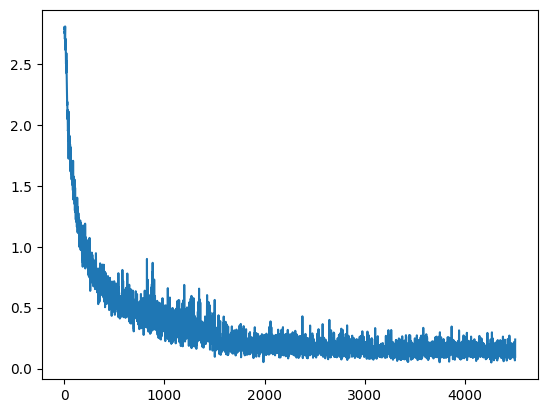

In [256]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot
l_losses=len(losses)
print(l_losses)
x = np.arange(1,l_losses+1,1)
#plt.xticks(x)
plot(x,losses)